In [1]:
# Downloading training data

import urllib
from pathlib import Path
from zipfile import ZipFile


URL = 'https://nnfs.io/datasets/fashion_mnist_images.zip'
FILE = 'fashion_mnist_images.zip'
FOLDER = 'fashion_mnist_images'

if not Path(FILE).is_file():
    print(f'Downloading {URL} and saving as {FILE}...')
    urllib.request.urlretrieve(URL, FILE)
    
    print(f'Unzipping images to ./{FOLDER}...')
    with ZipFile(FILE) as zf:
        zf.extractall(FOLDER)
    
    print('Done!')
else:
    print(f'{FILE} is found')

fashion_mnist_images.zip is found


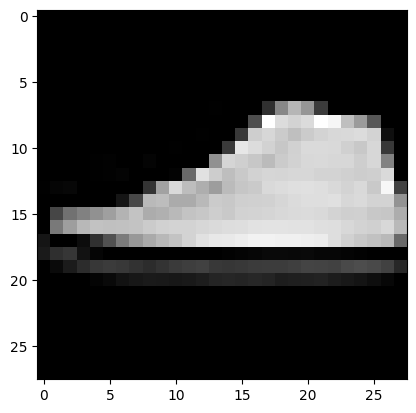

In [2]:
# Show an image from dataset

import cv2
import matplotlib.pyplot as plt

image_data = cv2.imread('fashion_mnist_images/train/7/0002.png', cv2.IMREAD_UNCHANGED)
plt.imshow(image_data, cmap='gray')
plt.show()

In [3]:
# Fill in X and y for training

import numpy as np


def load_mnist_dataset(path):
    labels = Path(FOLDER) / path

    X = []
    y = []
    for label in labels.iterdir():
        for file in label.iterdir():
            image = cv2.imread(str(file), cv2.IMREAD_UNCHANGED)
            X.append(image)
            y.append(label.name)
    
    return np.array(X), np.array(y).astype(np.uint8)


print('Loading up the training dataset...')
X, y = load_mnist_dataset('train')

print('Loading up the testing dataset...')
X_test, y_test = load_mnist_dataset('test')

print('Done!')

Loading up the training dataset...
Loading up the testing dataset...
Done!


In [4]:
# Scale the pixel values from (0 to 255) to (-1 to 1)

X = (X.astype(np.float32) - 127.5) / 127.5
X_test = (X_test.astype(np.float32) - 127.5) / 127.5

print(X.min(), X.max())
print(X.shape)

-1.0 1.0
(60000, 28, 28)


In [5]:
# Flatten images

X = X.reshape(X.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

print(X.shape)
print(X_test.shape)

(60000, 784)
(10000, 784)


In [6]:
# Shuffle the X and y

keys = np.array(range(X.shape[0]))
np.random.shuffle(keys)

X = X[keys]
y = y[keys]

print(y[:10])

[3 7 9 8 7 9 4 3 7 2]


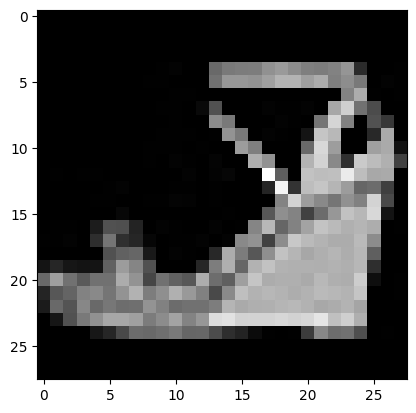

5


In [7]:
# Check whether the shuffling was applied correctly

plt.imshow(X[1337].reshape(28, 28), cmap='gray')
plt.show()

print(y[1337])

# (Check manually)

In [8]:
# Build the model and start training
# Managed to get this up to 89% validation accuracy and 0.33 loss

from src.model.model import Model

from src.layer.dense import Dense
from src.layer.dropout import Dropout
from src.activation.relu import ReLU
from src.activation.softmax import Softmax

from src.loss.categorical_crossentropy import CategoricalCrossentropy
from src.optimizers.adam import Adam
from src.accuracy.categorical import Categorical


model = Model(
    Dense(X.shape[1], 128),
    ReLU(),
    Dense(128, 128, l2_regularizer_w=5e-4, l2_regularizer_b=5e-4),
    Dropout(rate=0.1),
    ReLU(),
    Dense(128, 10),
    Softmax(),
    loss=CategoricalCrossentropy(),
    optimizer=Adam(learning_rate=0.0025, decay=1e-3),
    accuracy=Categorical()
)

model.train(X, y, validation_data=(X_test, y_test), epochs=10, batch_size=128, print_every=100)

--- Epoch 1 ---
step: 0, acc: 0.086, loss: 3.467 (data_loss: 3.385, reg_loss: 0.082), lr: 0.0025
step: 100, acc: 0.797, loss: 0.651 (data_loss: 0.587, reg_loss: 0.064), lr: 0.002274795268425842
step: 200, acc: 0.812, loss: 0.681 (data_loss: 0.625, reg_loss: 0.055), lr: 0.002085070892410342
step: 300, acc: 0.836, loss: 0.507 (data_loss: 0.458, reg_loss: 0.050), lr: 0.001924557351809084
step: 400, acc: 0.797, loss: 0.548 (data_loss: 0.502, reg_loss: 0.046), lr: 0.0017869907076483202
step: 468, acc: 0.812, loss: 0.531 (data_loss: 0.488, reg_loss: 0.043), lr: 0.0017041581458759373
Epoch 1 finished - acc: 0.685, loss: 0.5469338946283252 (data_loss: 0.504, reg_loss: 0.043), lr: 0.0017029972752043599

--- Epoch 2 ---
step: 0, acc: 0.891, loss: 0.390 (data_loss: 0.346, reg_loss: 0.043), lr: 0.0017029972752043599
step: 100, acc: 0.867, loss: 0.406 (data_loss: 0.365, reg_loss: 0.041), lr: 0.0015943877551020409
step: 200, acc: 0.812, loss: 0.544 (data_loss: 0.506, reg_loss: 0.039), lr: 0.00149880

In [9]:
# Evaluate model on the training data, because why not?

model.evaluate(X, y, batch_size=128)

Evaluation - acc: 0.919, loss: 0.218


In [10]:
# Save the model

SAVE_PATH = 'mnist_fashion_model.pkl'

model.save(SAVE_PATH)

print(f'Saved the model to {SAVE_PATH}')

Saved the model to mnist_fashion_model.pkl


In [11]:
# Check whether Model.save() is working properly

model = Model.load(SAVE_PATH)

model.evaluate(X, y, batch_size=128)

Evaluation - acc: 0.919, loss: 0.218
